In [123]:
import gc
import glob
import itertools
import os
# 
import lightgbm as lgb
import matplotlib
import matplotlib.pyplot as plt
import numpy as np  
import pandas as pd  
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split

from hyperopt import hp, tpe
from hyperopt.fmin import fmin

%matplotlib inline 
sns.set()
sns.set_style("darkgrid")
# plt.xkcd()

## 读取数据

In [80]:
# 辅助 list sort 进行排序
def takeNumber(str):
    return int(str.split('.')[-0][-2:])

In [81]:
def load_data(path, name, columns_name=None):
    all_file_path = glob.glob(os.path.join(path, name))
    all_file_path.sort(key=takeNumber)
    print('file read list : ', all_file_path)
    data = pd.concat((pd.read_csv(f, names=columns_name)
                          for f in all_file_path))
    return data

In [82]:
sensor_feature_train_path = '/home/dell/cutting_tool/train_feature'
plc_feature_train_path = '/usr/yushuyang/cutting_tool/feature/train/plc'
sensor_feature_test_path = '/home/dell/cutting_tool/test_feature'
# plc_feature_test_path = 'feature/train/plc'

In [83]:
time_feature_columns_name = ['ave_spindle', 'std_spindle', 'max_spindle', 'min_spindle', 'median_spindle', 'rmse_spindle',
                             'pp_spindle', 'hdiff_spindle', 'fdiff_spindle', 'ave_x', 'std_x', 'max_x', 'min_x', 'median_x', 'rmse_x',
                             'pp_x', 'hdiff_x', 'fdiff_x', 'ave_y', 'std_y', 'max_y', 'min_y', 'median_y', 'rmse_y', 'pp_y',
                             'hdiff_y', 'fdiff_y', 'ave_z', 'std_z', 'max_z', 'min_z', 'median_z', 'rmse_z', 'pp_z', 'hdiff_z', 'fdiff_z']

In [84]:
sensor_time_train_feature = load_data(sensor_feature_train_path, 'time_*.csv', time_feature_columns_name)
plc_time_train_feature = load_data(plc_feature_train_path, 'time_*.csv')

file read list :  ['/home/dell/cutting_tool/train_feature/time_train01.csv', '/home/dell/cutting_tool/train_feature/time_train02.csv', '/home/dell/cutting_tool/train_feature/time_train03.csv']
file read list :  ['/usr/yushuyang/cutting_tool/feature/train/plc/time_01.csv', '/usr/yushuyang/cutting_tool/feature/train/plc/time_02.csv', '/usr/yushuyang/cutting_tool/feature/train/plc/time_03.csv']


In [85]:
sensor_time_test_feature = load_data(sensor_feature_test_path, 'time_*.csv', time_feature_columns_name)

file read list :  ['/home/dell/cutting_tool/test_feature/time_test01.csv', '/home/dell/cutting_tool/test_feature/time_test02.csv', '/home/dell/cutting_tool/test_feature/time_test03.csv', '/home/dell/cutting_tool/test_feature/time_test04.csv', '/home/dell/cutting_tool/test_feature/time_test05.csv']


In [86]:
print('shape of train sensor time feature : ', sensor_time_train_feature.shape)
print('shape of train plc time feature : ',plc_time_train_feature.shape)

print('shape of test sensor time feature : ', sensor_time_test_feature.shape)

shape of train sensor time feature :  (133, 36)
shape of train plc time feature :  (133, 36)
shape of test sensor time feature :  (50, 36)


In [87]:
train_feature = pd.concat((sensor_time_train_feature, plc_time_train_feature), axis=1)

In [89]:
del sensor_time_train_feature, plc_time_train_feature
gc.collect()

66606

## 添加特征

### 频域

In [90]:
freq_feature_columns_name = ['freq_' + name for name in time_feature_columns_name]

In [91]:
sensor_freq_train_feature = load_data(sensor_feature_train_path, 'freq_train*.csv', freq_feature_columns_name)

file read list :  ['/home/dell/cutting_tool/train_feature/freq_train01.csv', '/home/dell/cutting_tool/train_feature/freq_train02.csv', '/home/dell/cutting_tool/train_feature/freq_train03.csv']


In [92]:
print('shape of sensor freq feature : ', sensor_freq_train_feature.shape)

shape of sensor freq feature :  (133, 36)


In [93]:
train_feature = pd.concat((train_feature, sensor_freq_train_feature), axis=1)

In [94]:
del sensor_freq_train_feature
gc.collect()

21

### 小波

In [95]:
wavelet_feature_columns_name = ['wavelet_vibration_1_cA3', 'wavelet_vibration_1_cD3', 'wavelet_vibration_1_cD2', 'wavelet_vibration_1_cD1',
                                'wavelet_vibration_1_cA3_enengy', 'wavelet_vibration_1_cD3_enengy', 'wavelet_vibration_1_cD2_enengy', 'wavelet_vibration_1_cD1_enengy',
                                'wavelet_vibration_1_total_energy', 'wavelet_vibration_2_cA3', 'wavelet_vibration_2_cD3', 'wavelet_vibration_2_cD2', 'wavelet_vibration_2_cD1',
                                'wavelet_vibration_2_cA3_enengy', 'wavelet_vibration_2_cD3_enengy', 'wavelet_vibration_2_cD2_enengy', 'wavelet_vibration_2_cD1_enengy',
                                'wavelet_vibration_2_total_energy', 'wavelet_vibration_3_cA3', 'wavelet_vibration_3_cD3', 'wavelet_vibration_3_cD2', 'wavelet_vibration_3_cD1',
                                'wavelet_vibration_3_cA3_enengy', 'wavelet_vibration_3_cD3_enengy', 'wavelet_vibration_3_cD2_enengy', 'wavelet_vibration_3_cD1_enengy',
                                'wavelet_vibration_3_total_energy', 'wavelet_cA3', 'wavelet_cD3', 'wavelet_cD2', 'wavelet_cD1',
                                'wavelet_cA3_enengy', 'wavelet_current_cD3_enengy', 'wavelet_current_cD2_enengy', 'wavelet_current_cD1_enengy',
                                'wavelet_current_total_energy']

In [96]:
wavelet_train_feature = load_data(sensor_feature_train_path, 'wavelet_train*.csv', wavelet_feature_columns_name)

file read list :  ['/home/dell/cutting_tool/train_feature/wavelet_train01.csv', '/home/dell/cutting_tool/train_feature/wavelet_train02.csv', '/home/dell/cutting_tool/train_feature/wavelet_train03.csv']


In [97]:
print('shape of sensor wavelet feature : ', wavelet_train_feature.shape)

shape of sensor wavelet feature :  (133, 36)


In [98]:
train_feature = pd.concat((train_feature, wavelet_train_feature), axis=1)

In [99]:
del wavelet_train_feature
gc.collect()

21

## 添加标签

In [100]:
train_run_cycle = [48, 48, 37]
test_run_cycle = [10, 10, 10, 10, 10]

In [101]:
train_label = list(itertools.chain.from_iterable(list(range(0, train_run_cycle[i] * 5, 5)[::-1]) for i in range(len(train_run_cycle))))
test_label = list(itertools.chain.from_iterable(list(range(0, test_run_cycle[i] * 5, 5)[::-1]) for i in range(len(test_run_cycle))))

In [104]:
train_data = train_feature.assign(label=train_label)

In [105]:
train_data = train_data.reset_index().reset_index()

In [107]:
train_data.rename(columns={'index': 'file_index', 'level_0': 'index'}, inplace=True)

## 验证集划分

In [109]:
# 随机划分，0.2
train, validation = train_test_split(train_data, test_size=0.20, random_state=0)

In [110]:
train.shape, validation.shape

((106, 147), (27, 147))

# model

In [111]:
# 学习率
def learning_rate_010_decay_power_099(current_iter):
    base_learning_rate = 0.1
    lr = base_learning_rate  * np.power(.99, current_iter)
    return lr if lr > 1e-3 else 1e-3

In [197]:
def rmse(y, y_pred):
    return np.sqrt(np.mean((y_pred - y)**2))
rmse_scorer = make_scorer(rmse, greater_is_better=False)

In [162]:
def base_model():
    params = {
        'num_leaves': 69,
        'n_estimators' : 20,
        'boosting_type' : 'gbdt',
        'max_depth' : 6,
        'learning_rate' : 0.05,
        'max_bin' : 255,
        'colsample_bytree' : 0.8,
        'min_child_samples' : 1,
        'reg_alpha' : 0,
        'reg_lambda' : 0,
        'metric' : 'rmse',
    }
    clf = lgb.LGBMRegressor(
        n_jobs=-1, 
        silent=False,
        **params
        )
    clf.fit(
        train.iloc[:, 2:-1],
        train['label'],
        eval_set=[(train.iloc[:, 2:-1], train['label']),
                  (validation.iloc[:, 2:-1], validation['label'])])
    return clf

In [163]:
model = base_model()

[1]	valid_0's rmse: 62.6738	valid_1's rmse: 65.6974
[2]	valid_0's rmse: 59.5887	valid_1's rmse: 63.1649
[3]	valid_0's rmse: 56.6498	valid_1's rmse: 61.209
[4]	valid_0's rmse: 53.8582	valid_1's rmse: 58.8861
[5]	valid_0's rmse: 51.2149	valid_1's rmse: 57.1958
[6]	valid_0's rmse: 48.7073	valid_1's rmse: 55.628
[7]	valid_0's rmse: 46.3246	valid_1's rmse: 54.1468
[8]	valid_0's rmse: 44.0544	valid_1's rmse: 52.5503
[9]	valid_0's rmse: 41.8744	valid_1's rmse: 51.0954
[10]	valid_0's rmse: 39.8251	valid_1's rmse: 49.5937
[11]	valid_0's rmse: 37.8832	valid_1's rmse: 48.3131
[12]	valid_0's rmse: 36.042	valid_1's rmse: 46.965
[13]	valid_0's rmse: 34.2951	valid_1's rmse: 45.9865
[14]	valid_0's rmse: 32.6264	valid_1's rmse: 44.8719
[15]	valid_0's rmse: 31.0433	valid_1's rmse: 43.8482
[16]	valid_0's rmse: 29.5311	valid_1's rmse: 42.9989
[17]	valid_0's rmse: 28.064	valid_1's rmse: 42.0076
[18]	valid_0's rmse: 26.6762	valid_1's rmse: 41.2317
[19]	valid_0's rmse: 25.3772	valid_1's rmse: 40.548
[20]	val

In [164]:
def plot_result(data, model):
    plot = pd.DataFrame({'index' : data['index'], 'predict' : model.predict(data.iloc[:, 2:-1]), 'label' : data['label']})
    plot = plot.sort_index(axis=0)
    plot = plot.melt('index', var_name='cols',  value_name='vals')    
    fig = plt.figure(figsize=(20, 5))
    ax = sns.pointplot(x="index", y="vals", hue='cols', data=plot)

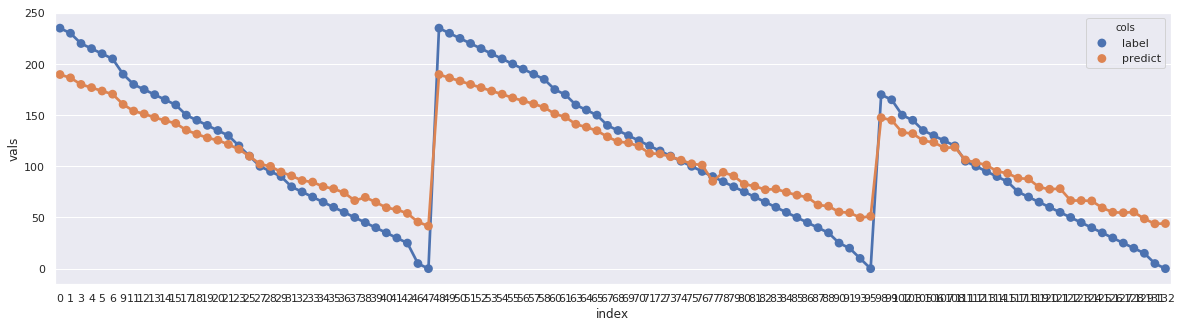

In [165]:
plot_result(train, model)

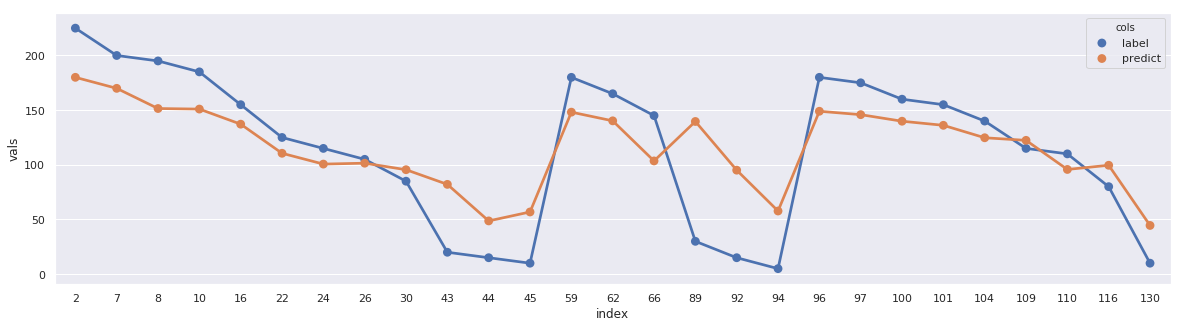

In [166]:
plot_result(validation, model)

## Hyperopt 调参

In [198]:
def params_search(params):
    params = {
        'num_leaves': int(params['num_leaves']),
        'n_estimators' : int(params['n_estimators'])
    }
    
    clf = lgb.LGBMRegressor(
        learning_rate=0.05,
        n_jobs=-1,
        **params
    )
    
    score = -cross_val_score(clf, train_data.iloc[:, 2:-1], train_data['label'], scoring=rmse_scorer, cv=5).mean()
    print("rmse score {:.3f} params {}".format(score, params))
    return score

In [199]:
space = {
    'num_leaves': hp.quniform('num_leaves', 31, 128, 3),
    'n_estimators': hp.quniform('n_estimators', 10, 20, 1)
}

In [200]:
best = fmin(fn=params_search,
            space=space,
            algo=tpe.suggest,
            max_evals=100)

rmse score 62.906 params {'num_leaves': 60, 'n_estimators': 11}
rmse score 61.798 params {'num_leaves': 60, 'n_estimators': 13}
rmse score 61.578 params {'num_leaves': 126, 'n_estimators': 14}
rmse score 60.595 params {'num_leaves': 48, 'n_estimators': 17}
rmse score 60.864 params {'num_leaves': 96, 'n_estimators': 16}
rmse score 61.798 params {'num_leaves': 69, 'n_estimators': 13}
rmse score 60.595 params {'num_leaves': 87, 'n_estimators': 17}
rmse score 60.115 params {'num_leaves': 93, 'n_estimators': 19}
rmse score 60.358 params {'num_leaves': 78, 'n_estimators': 18}
rmse score 61.222 params {'num_leaves': 33, 'n_estimators': 15}
rmse score 62.256 params {'num_leaves': 96, 'n_estimators': 12}
rmse score 62.906 params {'num_leaves': 108, 'n_estimators': 11}
rmse score 61.578 params {'num_leaves': 66, 'n_estimators': 14}
rmse score 61.578 params {'num_leaves': 102, 'n_estimators': 14}
rmse score 60.595 params {'num_leaves': 99, 'n_estimators': 17}
rmse score 62.906 params {'num_leaves

In [201]:
print("Hyperopt estimated optimum {}".format(best))

Hyperopt estimated optimum {'n_estimators': 20.0, 'num_leaves': 126.0}


In [202]:
params_search(best)

rmse score 59.700 params {'num_leaves': 126, 'n_estimators': 20}


59.699667142698857